See https://medium.com/kx-systems/guide-to-multimodal-rag-for-images-and-text-10dab36e3117

In [19]:
import os
import sys 
sys.path.append(r'C:\Users\ELAFACRB1\Codice\GitHub\rio-utils-app\src')
from utils.database_managers import QDrantDBManager
from utils.embedding import EmbeddingFunction
from utils.text_processing import TextSplitter
from utils.language_models import LangChainAI
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [20]:
embedding = EmbeddingFunction('fast-bgeEmbedding').embedder

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 5011.12it/s]


In [21]:
text_splitter = TextSplitter(
    chunk_size=2000, 
    chunk_overlap=20
)

In [22]:

QDRANT_URL=os.getenv('QDRANT_URL')
COLLECTION_NAME="web-places"

qdrantClient = QDrantDBManager(
    url=QDRANT_URL,
    port=6333,
    collection_name=COLLECTION_NAME,
    vector_size=768,
    embedding=embedding,
    record_manager_url="sqlite:///record_manager_cache.sql"
)


Collection web-places already exists!


In [23]:
retriever = qdrantClient.vector_store.as_retriever()

In [24]:
question = "dove posso mangiare in montagna ?"

In [25]:
retriever.invoke(question)

[Document(page_content='Montevecchia √® uno dei nostri posti del cuore in Brianza, merito della sua posizione stupenda su una collina a 500 metri d‚Äôaltezza, affacciata sulle vigne circostanti e da cui (nei giorni pi√π limpidi) si vede addirittura lo skyline milanese. Un modo per godervi questo panorama fantastico √® fermarvi per un aperitivo o una pasto semplice ma efficace ai Giardini di Eva, vicino alla piazzetta principale. Potrete dividere taglieri di salumi e formaggi (9-18‚Ç¨) oppure optare per piatti ‚Äòalla griglia‚Äô come panino con salamella (5‚Ç¨) o arrosticini di pecora (8‚Ç¨). Per accompagnare, vi consigliamo di approfittare della ricca selezione di birre artigianali sul menu (buonissima La Grigna!). Un locale senza pretese ma davvero piacevole d‚Äôestate, soprattutto se riuscite a farvi dare uno degli ambiti tavoli con vista. Se venite a pranzo, approfittatene poi per fare una passeggiata nel verde al Parco del Curone! Una raccomandazione: ricordatevi che nel weekend, p

# Multimodal RAG

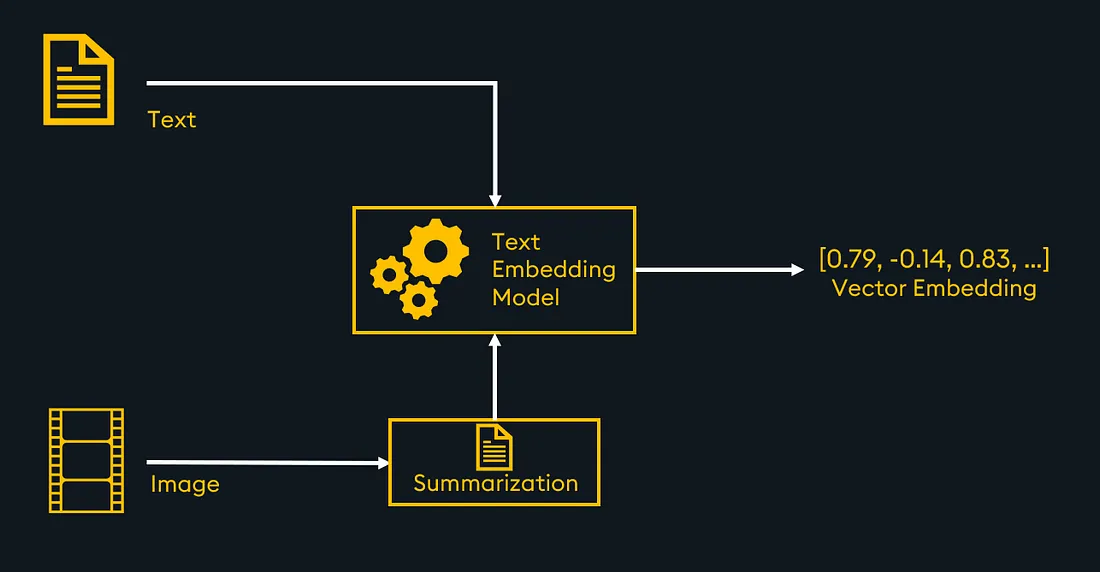

The way to approach multimodal retrieval and RAG is to transform all of your data into a single modality: text. This means that you only need to use a text embedding model to store all of your data within the same vector space. This comes with an additional cost of initially summarizing other types of data like images, video, or audio either manually or with an LLM.

In [26]:
import base64
import openai
import pandas as pd

In [27]:

# Helper function to convert a file to base64 representation
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [28]:
# Takes in a base64 encoded image and prompt (requesting an image summary)
# Returns a response from the LLM (image summary)
def image_summarize(img_base64,prompt):
    ''' Image summary '''
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{img_base64}",
                },
                },
            ],
            }
        ],
        max_tokens=150,
    )
    content = response.choices[0].message.content
    return content

In [29]:
#Define a dataframe to put our embeddings and metadata into 
#this will later be used to load our vector database
columns = ['path','media_type','text','embeddings']
df = pd.DataFrame(columns=columns)

#Get a list of paths for images, text
images = os.listdir("./data/images")
texts = os.listdir("./data/text")

In [30]:
# # Embed texts, store relevant info in data frame
# for text in texts:
#     path = "./data/text/" + text
#     media_type = "text"
#     text1 = read_text_from_file(path)
#     embedding = TexttoEmbedding(text1)
#     new_row = {'path': path,
#                'media_type':'text',
#                'text' : text1,
#                'embeddings': embedding}
#     df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [33]:
# Encode images with base64 encoding, 
# Get text summary for encoded images, 
# Embed summary, store relevant info in data frame
for image in images:
    path = "./data/images/" + image
    media_type = "images"
    base64_image = encode_image(path)
    prompt = "Descrivi l'immagine in dettaglio."
    summarization = image_summarize(base64_image,prompt)

    print(summarization)
    # embedding = embedding(summarization)
    
    

L'immagine mostra una parata militare in cui diversi soldati stanno marciando a cavallo di cammelli. I soldati indossano uniformi, bergetti e portano armi. I cammelli sono decorati con coperte rosse adornate riccamente che coprono il loro dorso, probabilmente facendo parte dell'equipaggiamento militare cerimoniale. La parata si svolge su una strada asfaltata in un'area aperta e leggermente nebbiosa. Sullo sfondo, diverse altre unità di cammelli sono visibili, allineate dietro il gruppo principale. L'immagine trasmette un senso di ordine e disciplina militare. La


In [ ]:
# new_row = {'path': path,
#                'media_type':'image',
#                'text' : summarization,
#                'embeddings': embedding}
#     df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)